In [28]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Model
from tensorflow.keras.utils import img_to_array, load_img
from shutil import copyfile
from PIL import Image
%matplotlib inline

In [29]:
print(tf.__version__)

2.12.0


In [30]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>=0.94):
      self.model.stop_training = True

callbacks = myCallback()

In [31]:
# Resized gambar agar memiliku jumlah pixel yang sama
def copy_to_working(path, new_path):
    for dirname in os.listdir(path):
      for filename in os.scandir(os.path.join(path, dirname)):
        copyfile(os.path.join(path, dirname, filename.name), os.path.join(new_path, dirname, filename.name))

In [32]:
# Membuat fungsi untuk menyalin data dari sumber data ke train dan test dir seusai yang diinginkan

def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, TESTING_DIR, SPLIT_SIZE):
  all_files = []

  for file_name in os.listdir(SOURCE_DIR):
      file_path = SOURCE_DIR + file_name

      if os.path.getsize(file_path):
          all_files.append(file_name)
      else:
          print('{} is zero length, so ignoring'.format(file_name))

  train_val_size = int(SPLIT_SIZE * len(all_files))
  val_test_size = int(len(all_files) - int((len(all_files)-train_val_size)/2))
  shuffled = random.sample(all_files, len(all_files))
  train, val, test = shuffled[:train_val_size], shuffled[train_val_size:val_test_size], shuffled[val_test_size:]

  for filename in train:
    copyfile(SOURCE_DIR + filename, TRAINING_DIR + filename)

  for filename in val:
    copyfile(SOURCE_DIR + filename, VALIDATION_DIR + filename)

  for filename in test:
    copyfile(SOURCE_DIR + filename, TESTING_DIR + filename)

In [33]:
# Membuat direktori untuk menempatka data yang akan digunakan

root_dir = '/kaggle/working/coffee-leaf-diseases'
tmp_dir = '/kaggle/working/tmp'
source_dir = '/kaggle/input/coffee-disease/Coffee_Disease_Dataset'

if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

if os.path.exists(tmp_dir):
  shutil.rmtree(tmp_dir)

os.mkdir(tmp_dir)
os.mkdir(os.path.join(tmp_dir, 'cerscospora'))
os.mkdir(os.path.join(tmp_dir, 'miner'))
os.mkdir(os.path.join(tmp_dir, 'nodisease'))
os.mkdir(os.path.join(tmp_dir, 'phoma'))
os.mkdir(os.path.join(tmp_dir, 'rust'))

def create_train_test_dirs(root_path):
  os.mkdir(root_path)
  os.mkdir(os.path.join(root_path, 'train'))
  os.mkdir(os.path.join(root_path, 'val'))
  os.mkdir(os.path.join(root_path, 'test'))

  for foldername in os.listdir(os.path.join(source_dir)):
    for i in os.listdir(root_path):
      os.mkdir(os.path.join(root_path, i, foldername))

try:
  create_train_test_dirs(root_path=root_dir)
except FileExistsError:
  print("File Sudah Ada")

In [34]:
# Lokasi Semua Dataset Utama
# Lokasi Dataset Tiap Penyakit
cerscospora_source = os.path.join(source_dir, 'cerscospora/')
healthy_source = os.path.join(source_dir, 'nodisease/')
miner_source = os.path.join(source_dir, 'miner/')
phoma_source = os.path.join(source_dir, 'phoma/')
rust_source = os.path.join(source_dir, 'rust/')

# Lokasi Dataset Tiap Penyakit
cerscospora_tmp = os.path.join(tmp_dir, 'cerscospora/')
healthy_tmp = os.path.join(tmp_dir, 'nodisease/')
miner_tmp = os.path.join(tmp_dir, 'miner/')
phoma_tmp = os.path.join(tmp_dir, 'phoma/')
rust_tmp = os.path.join(tmp_dir, 'rust/')

# Lokasi Utama Dataset Setelah Dibagi
train_dir = os.path.join(root_dir, 'train/')
val_dir = os.path.join(root_dir, 'val/')
test_dir = os.path.join(root_dir, 'test/')

# Lokasi Dataset Training Tiap Penyakit Setelah Di Bagi
train_cerscospora_dir = os.path.join(train_dir, 'cerscospora/')
train_healthty_dir = os.path.join(train_dir, 'nodisease/')
train_miner_dir = os.path.join(train_dir, 'miner/')
train_phoma_dir = os.path.join(train_dir, 'phoma/')
train_rust_dir = os.path.join(train_dir, 'rust/')

# Lokasi Dataset Validation Tiap Penyakit Setelah Di Bagi
val_cerscospora_dir = os.path.join(val_dir, 'cerscospora/')
val_healthty_dir = os.path.join(val_dir, 'nodisease/')
val_miner_dir = os.path.join(val_dir, 'miner/')
val_phoma_dir = os.path.join(val_dir, 'phoma/')
val_rust_dir = os.path.join(val_dir, 'rust/')

# Lokasi Dataset Testing Tiap Penyakit Setelah Di Bagi
test_cerscospora_dir = os.path.join(test_dir, 'cerscospora/')
test_healthty_dir = os.path.join(test_dir, 'nodisease/')
test_miner_dir = os.path.join(test_dir, 'miner/')
test_phoma_dir = os.path.join(test_dir, 'phoma/')
test_rust_dir = os.path.join(test_dir, 'rust/')

In [35]:
# Melihat contoh ukuran dataset
sample_image  = load_img('/kaggle/input/coffee-disease/Coffee_Disease_Dataset/miner/100.jpg')
sample_array = img_to_array(sample_image)
print(f"Each image has shape: {sample_array.shape}")

sample_image  = load_img('/kaggle/input/coffee-disease/Coffee_Disease_Dataset/cerscospora/12088928264_a953dbfae1_b.jpg')
sample_array = img_to_array(sample_image)
print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (1024, 2048, 3)
Each image has shape: (626, 847, 3)


In [36]:
copy_to_working(source_dir, tmp_dir)

In [37]:
# # Jumlah gambar yang ingin tersisa di setiap folder
# jumlah_tersisa = 3000

# for folder in os.listdir(tmp_dir):
#     # Dapatkan daftar semua file gambar dalam folder
#     gambar = [file for file in os.listdir(os.path.join(tmp_dir, folder)) if file.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

#     # Pastikan jumlah gambar yang ingin tersisa tidak melebihi jumlah gambar yang ada
#     jumlah_tersisa = min(jumlah_tersisa, len(gambar))

#     # Jumlah gambar yang akan dihapus
#     jumlah_hapus = len(gambar) - jumlah_tersisa

#     # Acak urutan gambar
#     random.shuffle(gambar)

#     # Hapus gambar secara acak sampai tersisa jumlah tertentu
#     for i in range(jumlah_hapus):
#         file = os.path.join(tmp_dir, folder, gambar[i])
#         os.remove(file)

# print('Penghapusan selesai.')

In [38]:
file_count = len([f for f in os.listdir("/kaggle/working/tmp/rust") if os.path.isfile(os.path.join("/kaggle/working/tmp/rust", f))])
print(f"Jumlah file dalam folder Leaf Rust: {file_count}")
file_count = len([f for f in os.listdir("/kaggle/working/tmp/cerscospora") if os.path.isfile(os.path.join("/kaggle/working/tmp/cerscospora", f))])
print(f"Jumlah file dalam folder Cerscospora: {file_count}")
file_count = len([f for f in os.listdir("/kaggle/working/tmp/miner") if os.path.isfile(os.path.join("/kaggle/working/tmp/miner", f))])
print(f"Jumlah file dalam folder Miner: {file_count}")
file_count = len([f for f in os.listdir("/kaggle/working/tmp/phoma") if os.path.isfile(os.path.join("/kaggle/working/tmp/phoma", f))])
print(f"Jumlah file dalam folder Phoma: {file_count}")
file_count = len([f for f in os.listdir("/kaggle/working/tmp/nodisease") if os.path.isfile(os.path.join("/kaggle/working/tmp/nodisease", f))])
print(f"Jumlah file dalam folder Healthy: {file_count}")

Jumlah file dalam folder Leaf Rust: 340
Jumlah file dalam folder Cerscospora: 335
Jumlah file dalam folder Miner: 492
Jumlah file dalam folder Phoma: 492
Jumlah file dalam folder Healthy: 427


In [39]:
# Pisahkan dan salin data mengguakan fungsi split_data
split_size = .6

split_data(cerscospora_tmp, train_cerscospora_dir, val_cerscospora_dir, test_cerscospora_dir, split_size)
split_data(healthy_tmp, train_healthty_dir, val_healthty_dir, test_healthty_dir, split_size)
split_data(miner_tmp, train_miner_dir, val_miner_dir, test_miner_dir, split_size)
split_data(phoma_tmp, train_phoma_dir, val_phoma_dir, test_phoma_dir, split_size)
split_data(rust_tmp, train_rust_dir, val_rust_dir, test_rust_dir, split_size)

In [40]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Tentukan path folder train dan test
train_dir = '/kaggle/working/coffee-leaf-diseases/train'
val_dir = '/kaggle/working/coffee-leaf-diseases/val'
test_dir = '/kaggle/working/coffee-leaf-diseases/test'

# Load dataset train menjadi array numpy
train_images = []
train_labels = []
val_images = []
val_labels = []
test_images = []
test_labels = []
classes = ['cerscospora', 'nodisease', 'miner', 'phoma', 'rust']
for class_index, class_name in enumerate(classes):
    class_dir = os.path.join(train_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        img = Image.open(image_path).convert('RGB')
        img = img.resize((300, 150), Image.Resampling.LANCZOS)
        inp_numpy = np.array(img)[None]
        image_array = tf.constant(inp_numpy, dtype='float32')
        train_images.append(image_array)
        train_labels.append(class_index)
    class_dir = os.path.join(val_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        img = Image.open(image_path).convert('RGB')
        img = img.resize((300, 150), Image.Resampling.LANCZOS)
        inp_numpy = np.array(img)[None]
        image_array = tf.constant(inp_numpy, dtype='float32')
        val_images.append(image_array)
        val_labels.append(class_index)
    class_dir = os.path.join(test_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        img = Image.open(image_path).convert('RGB')
        img = img.resize((300, 150), Image.Resampling.LANCZOS)
        inp_numpy = np.array(img)[None]
        image_array = tf.constant(inp_numpy, dtype='float32')
        test_images.append(image_array)
        test_labels.append(class_index)

train_images = np.array(train_images)
train_labels = np.array(train_labels)
val_images = np.array(val_images)
val_labels = np.array(val_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Konversi dataset train menjadi tf.constant
train_images = tf.constant(np.squeeze(train_images), dtype=tf.float32)
train_labels = tf.constant(train_labels, dtype=tf.int32)
val_images = tf.constant(np.squeeze(val_images), dtype=tf.float32)
val_labels = tf.constant(val_labels, dtype=tf.int32)
test_images = tf.constant(np.squeeze(test_images), dtype=tf.float32)
test_labels = tf.constant(test_labels, dtype=tf.int32)

In [41]:
# Buat model untuk melatih data
EfficientNet = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(150, 300, 3),
)

for layer in EfficientNet.layers:
    layer.trainable = False
    
# start = EfficientNet.get_layer('block4c_add')


x = tf.keras.layers.Flatten()(EfficientNet.output)
x = tf.keras.layers.Dense(5, activation='softmax')(x)

model = Model(EfficientNet.input, x)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 150, 300, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 150, 300, 3)  7          ['rescaling_6[0][0]']            
 )                                                                                                
                                                                                            

# Model with Learning Rate 1e-4

In [42]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
history = model.fit(train_images,
                    train_labels,
                    epochs=25,
                    verbose=1,
                    validation_data=(val_images, val_labels)
                   )

Epoch 1/25


2023-08-14 09:23:05.098270: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 13s 135ms/step - loss: 0.8588 - accuracy: 0.6643 - val_loss: 0.4137 - val_accuracy: 0.8687
Epoch 2/25
40/40 [==============================] - 3s 77ms/step - loss: 0.3008 - accuracy: 0.9041 - val_loss: 0.3366 - val_accuracy: 0.8950
Epoch 3/25
40/40 [==============================] - 3s 77ms/step - loss: 0.1786 - accuracy: 0.9552 - val_loss: 0.3031 - val_accuracy: 0.9021
Epoch 4/25
40/40 [==============================] - 3s 77ms/step - loss: 0.1325 - accuracy: 0.9696 - val_loss: 0.2558 - val_accuracy: 0.9141
Epoch 5/25
40/40 [==============================] - 4s 91ms/step - loss: 0.0855 - accuracy: 0.9864 - val_loss: 0.2362 - val_accuracy: 0.9141
Epoch 6/25
40/40 [==============================] - 4s 91ms/step - loss: 0.0694 - accuracy: 0.9904 - val_loss: 0.2381 - val_accuracy: 0.9260
Epoch 7/25
40/40 [==============================] - 3s 81ms/step - loss: 0.0647 - accuracy: 0.9872 - val_loss: 0.2191 - val_accuracy: 0.9260
Epoch 8/25
40/40 [====

In [44]:
model.evaluate(test_images, test_labels)

13/13 [==============================] - 1s 62ms/step - loss: 0.1321 - accuracy: 0.9495


[0.13207238912582397, 0.9495192170143127]

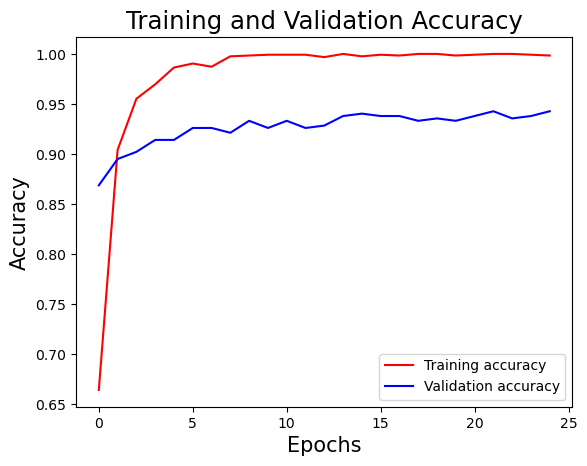

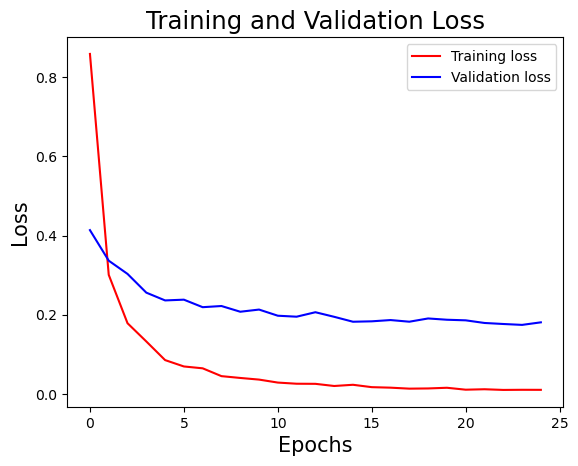

13/13 [==============================] - 2s 59ms/step


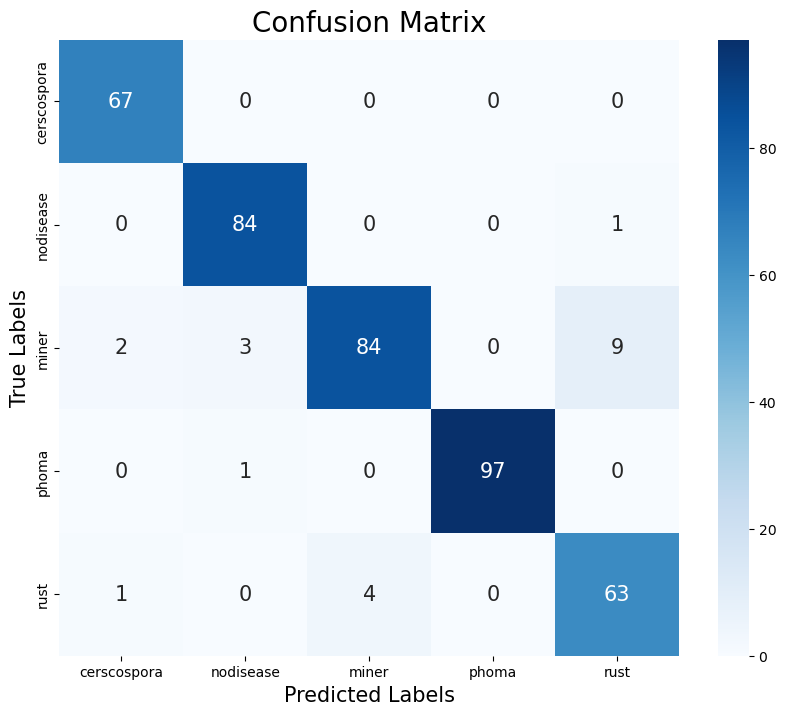

In [45]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#Train and Validation Accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy', size=17.5)
plt.legend(loc=0)
plt.xlabel("Epochs", size=15)
plt.ylabel("Accuracy", size=15)
plt.savefig('Accuracy_lr_1e-4.png')
plt.show()

#Train and Validation Loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss', size=17.5)
plt.legend(loc=0)
plt.xlabel("Epochs", size=15)
plt.ylabel("Loss", size=15)
plt.savefig('Loss_lr_1e-4.png')
plt.show()

# Confusion Matrix Heatmap
# class_labels = sorted(os.listdir('/kaggle/input/coffee-leaf-diseases/train'))
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
# true_labels = val_generator.classes
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={'size': 15})
plt.xlabel('Predicted Labels', size=15)
plt.ylabel('True Labels', size=15)
plt.title('Confusion Matrix', size=20)
plt.savefig('Confusion Matrix_lr_1e-4.png')
plt.show()

In [46]:
import pandas as pd
pd.DataFrame({
    'acc': acc,
    'val_acc': val_acc,
    'loss': loss,
    'val_loss': val_loss,
})

,acc,val_acc,loss,val_loss
0,0.664269,0.868735,0.858817,0.413749
1,0.904077,0.894988,0.300802,0.336569
2,0.955236,0.902148,0.178588,0.303149
3,0.969624,0.914081,0.132543,0.255847
4,0.986411,0.914081,0.085484,0.236199
5,0.990408,0.926014,0.069408,0.238105
6,0.987210,0.926014,0.064718,0.219128
7,0.997602,0.921241,0.044951,0.222075
8,0.998401,0.933174,0.040385,0.207629
9,0.999201,0.926014,0.036234,0.213106


In [47]:
prediksi = model.predict(test_images)
y_pred = np.argmax(prediksi, axis=1)
# y_true = val_generator.labels

print(classification_report(test_labels, y_pred))

13/13 [==============================] - 1s 53ms/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        67
           1       0.95      0.99      0.97        85
           2       0.95      0.86      0.90        98
           3       1.00      0.99      0.99        98
           4       0.86      0.93      0.89        68

    accuracy                           0.95       416
   macro avg       0.95      0.95      0.95       416
weighted avg       0.95      0.95      0.95       416



In [48]:
# Save model dengan format Protobuf
tf.saved_model.save(model, "/kaggle/working/Model")
my_model = tf.saved_model.load('/kaggle/working/Model')

# convert model ke TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
tflite_model = converter.convert()

# save TFLite model
with open('Coffee_disease_EfficientNetB0_lr_1e-4.tflite', 'wb') as f:
  f.write(tflite_model)

# Model with Learning Rate 5e-4

In [49]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
history = model.fit(train_images,
                    train_labels,
                    epochs=25,
                    verbose=1,
                    validation_data=(val_images, val_labels)
                   )

Epoch 1/25


2023-08-14 09:27:05.170771: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 12s 132ms/step - loss: 0.2102 - accuracy: 0.9361 - val_loss: 0.7531 - val_accuracy: 0.8305
Epoch 2/25
40/40 [==============================] - 3s 78ms/step - loss: 0.1205 - accuracy: 0.9624 - val_loss: 0.3859 - val_accuracy: 0.9069
Epoch 3/25
40/40 [==============================] - 4s 91ms/step - loss: 0.0652 - accuracy: 0.9784 - val_loss: 0.4945 - val_accuracy: 0.8831
Epoch 4/25
40/40 [==============================] - 4s 91ms/step - loss: 0.0416 - accuracy: 0.9896 - val_loss: 0.3898 - val_accuracy: 0.9045
Epoch 5/25
40/40 [==============================] - 4s 91ms/step - loss: 0.0219 - accuracy: 0.9928 - val_loss: 0.3532 - val_accuracy: 0.9356
Epoch 6/25
40/40 [==============================] - 4s 91ms/step - loss: 0.0258 - accuracy: 0.9880 - val_loss: 0.5557 - val_accuracy: 0.8759
Epoch 7/25
40/40 [==============================] - 4s 91ms/step - loss: 0.0260 - accuracy: 0.9912 - val_loss: 0.4134 - val_accuracy: 0.9045
Epoch 8/25
40/40 [====

In [51]:
model.evaluate(test_images, test_labels)

13/13 [==============================] - 1s 60ms/step - loss: 0.3006 - accuracy: 0.9399


[0.30061477422714233, 0.9399038553237915]

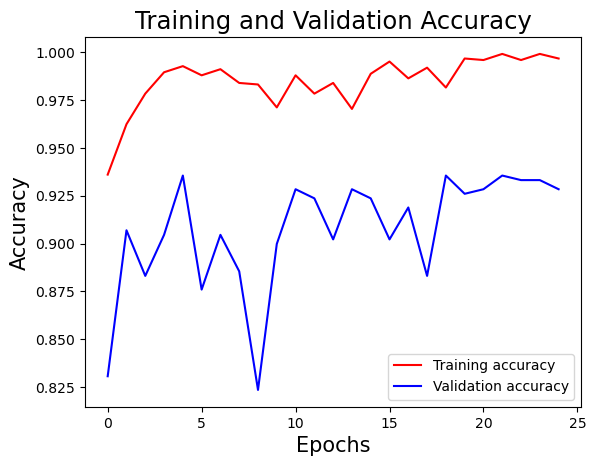

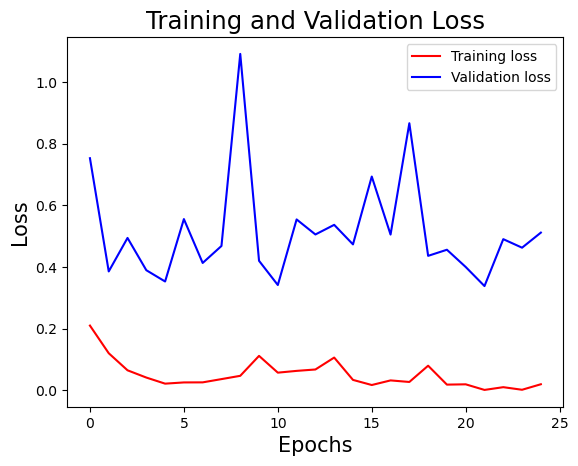

13/13 [==============================] - 2s 59ms/step


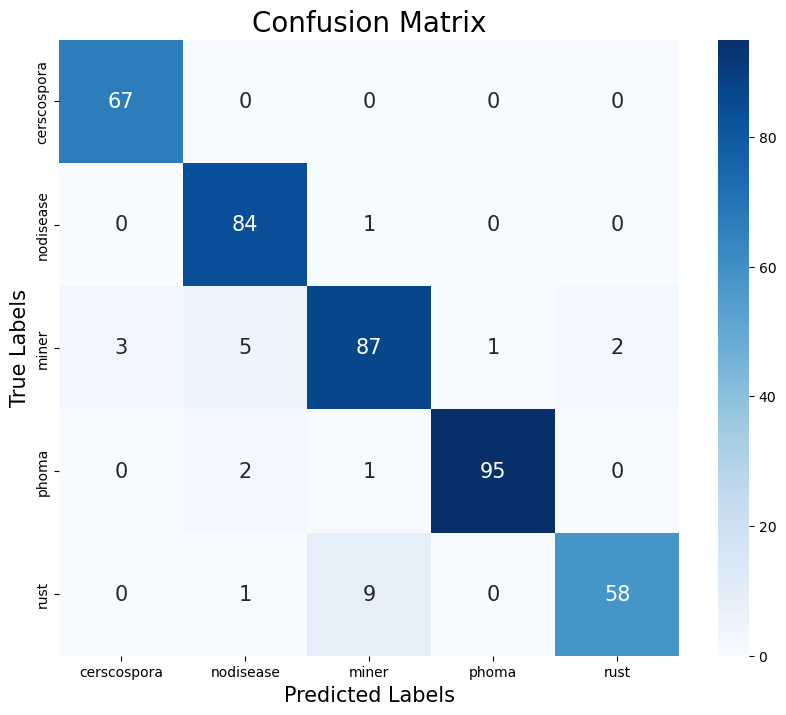

In [52]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#Train and Validation Accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy', size=17.5)
plt.legend(loc=0)
plt.xlabel("Epochs", size=15)
plt.ylabel("Accuracy", size=15)
plt.savefig('Accuracy_lr_5e-4.png')
plt.show()

#Train and Validation Loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss', size=17.5)
plt.legend(loc=0)
plt.xlabel("Epochs", size=15)
plt.ylabel("Loss", size=15)
plt.savefig('Loss_lr_5e-4.png')
plt.show()

# Confusion Matrix Heatmap
# class_labels = sorted(os.listdir('/kaggle/input/coffee-leaf-diseases/train'))
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
# true_labels = val_generator.classes
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={'size': 15})
plt.xlabel('Predicted Labels', size=15)
plt.ylabel('True Labels', size=15)
plt.title('Confusion Matrix', size=20)
plt.savefig('Confusion Matrix_lr_5e-4.png')
plt.show()

In [53]:
import pandas as pd
pd.DataFrame({
    'acc': acc,
    'val_acc': val_acc,
    'loss': loss,
    'val_loss': val_loss,
})

,acc,val_acc,loss,val_loss
0,0.936051,0.830549,0.210205,0.753132
1,0.962430,0.906921,0.120523,0.385883
2,0.978417,0.883055,0.065174,0.494522
3,0.989608,0.904535,0.041645,0.389839
4,0.992806,0.935561,0.021882,0.353240
5,0.988010,0.875895,0.025834,0.555689
6,0.991207,0.904535,0.026045,0.413410
7,0.984013,0.885442,0.036610,0.468449
8,0.983213,0.823389,0.047274,1.091399
9,0.971223,0.899761,0.111948,0.420363


In [54]:
prediksi = model.predict(test_images)
y_pred = np.argmax(prediksi, axis=1)
# y_true = val_generator.labels

print(classification_report(test_labels, y_pred))

13/13 [==============================] - 1s 54ms/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        67
           1       0.91      0.99      0.95        85
           2       0.89      0.89      0.89        98
           3       0.99      0.97      0.98        98
           4       0.97      0.85      0.91        68

    accuracy                           0.94       416
   macro avg       0.94      0.94      0.94       416
weighted avg       0.94      0.94      0.94       416



In [55]:
# Save model dengan format Protobuf
tf.saved_model.save(model, "/kaggle/working/Model")
my_model = tf.saved_model.load('/kaggle/working/Model')

# convert model ke TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
tflite_model = converter.convert()

# save TFLite model
with open('Coffee_disease_EfficientNetB0_lr_5e-4.tflite', 'wb') as f:
  f.write(tflite_model)

# Model with Learning Rate 1e-3

In [91]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [92]:
history = model.fit(train_images,
                    train_labels,
                    epochs=25,
                    verbose=1,
                    validation_data=(val_images, val_labels)
                   )

Epoch 1/25


2023-08-14 09:51:36.762866: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 12s 118ms/step - loss: 0.0322 - accuracy: 0.9976 - val_loss: 2.3238 - val_accuracy: 0.9475
Epoch 2/25
40/40 [==============================] - 4s 92ms/step - loss: 0.0779 - accuracy: 0.9920 - val_loss: 2.3896 - val_accuracy: 0.9403
Epoch 3/25
40/40 [==============================] - 3s 84ms/step - loss: 0.0747 - accuracy: 0.9960 - val_loss: 2.3940 - val_accuracy: 0.9332
Epoch 4/25
40/40 [==============================] - 4s 92ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 2.8205 - val_accuracy: 0.9308
Epoch 5/25
40/40 [==============================] - 3s 78ms/step - loss: 0.0246 - accuracy: 0.9984 - val_loss: 2.6789 - val_accuracy: 0.9212
Epoch 6/25
40/40 [==============================] - 3s 78ms/step - loss: 0.0113 - accuracy: 0.9984 - val_loss: 2.5815 - val_accuracy: 0.9284
Epoch 7/25
40/40 [==============================] - 4s 91ms/step - loss: 0.0163 - accuracy: 0.9984 - val_loss: 2.1388 - val_accuracy: 0.9403
Epoch 8/25
40/40 [====

In [93]:
model.evaluate(test_images, test_labels)

13/13 [==============================] - 1s 63ms/step - loss: 2.3066 - accuracy: 0.9351


[2.306565999984741, 0.9350961446762085]

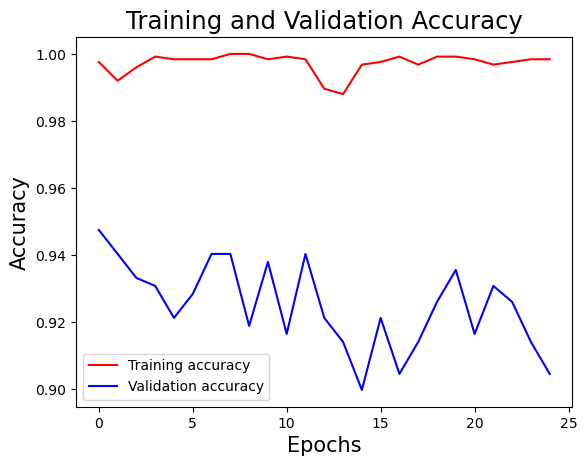

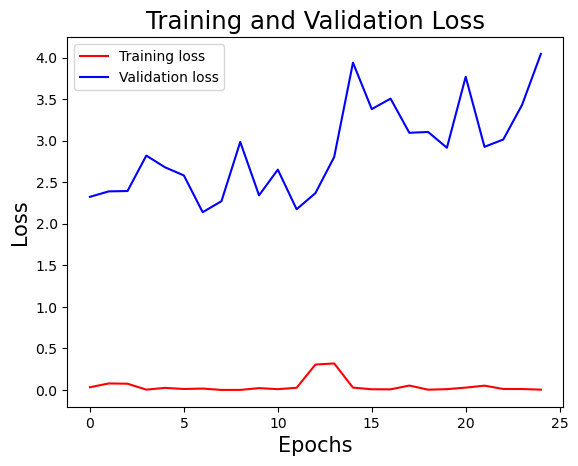

13/13 [==============================] - 2s 60ms/step


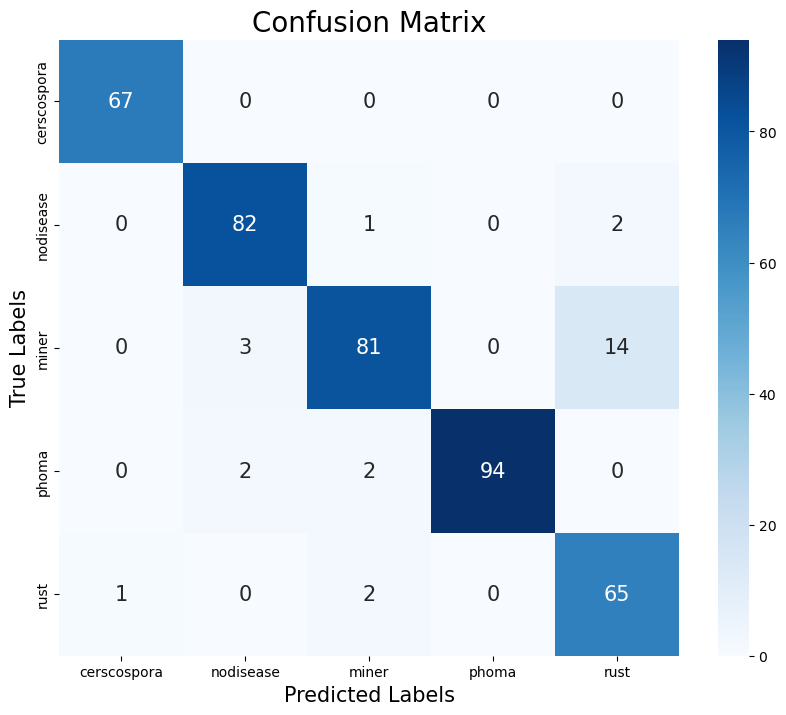

In [94]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#Train and Validation Accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy', size=17.5)
plt.legend(loc=0)
plt.xlabel("Epochs", size=15)
plt.ylabel("Accuracy", size=15)
plt.savefig('Accuracy_lr_1e-3.png')
plt.show()

#Train and Validation Loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss', size=17.5)
plt.legend(loc=0)
plt.xlabel("Epochs", size=15)
plt.ylabel("Loss", size=15)
plt.savefig('Loss_lr_1e-3.png')
plt.show()

# Confusion Matrix Heatmap
# class_labels = sorted(os.listdir('/kaggle/input/coffee-leaf-diseases/train'))
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
# true_labels = val_generator.classes
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={'size': 15})
plt.xlabel('Predicted Labels', size=15)
plt.ylabel('True Labels', size=15)
plt.title('Confusion Matrix', size=20)
plt.savefig('Confusion Matrix_lr_1e-3.png')
plt.show()

In [95]:
import pandas as pd
pd.DataFrame({
    'acc': acc,
    'val_acc': val_acc,
    'loss': loss,
    'val_loss': val_loss,
})

,acc,val_acc,loss,val_loss
0,0.997602,0.947494,3.223191e-02,2.323849
1,0.992006,0.940334,7.791612e-02,2.389613
2,0.996003,0.933174,7.473446e-02,2.393965
3,0.999201,0.930788,3.511148e-03,2.820473
4,0.998401,0.921241,2.456129e-02,2.678940
5,0.998401,0.928401,1.128067e-02,2.581468
6,0.998401,0.940334,1.633330e-02,2.138840
7,1.000000,0.940334,3.427844e-07,2.271765
8,1.000000,0.918854,3.285140e-04,2.984825
9,0.998401,0.937948,2.154088e-02,2.342367


In [96]:
prediksi = model.predict(test_images)
y_pred = np.argmax(prediksi, axis=1)
# y_true = val_generator.labels

print(classification_report(test_labels, y_pred))

13/13 [==============================] - 1s 55ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        67
           1       0.94      0.96      0.95        85
           2       0.94      0.83      0.88        98
           3       1.00      0.96      0.98        98
           4       0.80      0.96      0.87        68

    accuracy                           0.94       416
   macro avg       0.93      0.94      0.94       416
weighted avg       0.94      0.94      0.94       416



In [76]:
# Save model dengan format Protobuf
tf.saved_model.save(model, "/kaggle/working/Model")
my_model = tf.saved_model.load('/kaggle/working/Model')

# convert model ke TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
tflite_model = converter.convert()

# save TFLite model
with open('Coffee_disease_EfficientNetB0_lr_1e-3.tflite', 'wb') as f:
  f.write(tflite_model)

In [63]:
print("Train")
print("Cerscospora:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/train/cerscospora")))
print("No Disease:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/train/nodisease")))
print("Miner:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/train/miner")))
print("Phoma:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/train/phoma")))
print("Rust:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/train/rust")))

print("\nVal")
print("Cerscospora:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/val/cerscospora")))
print("No Disease:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/val/nodisease")))
print("Miner:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/val/miner")))
print("Phoma:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/val/phoma")))
print("Rust:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/val/rust")))

print("\nTest")
print("Cerscospora:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/test/cerscospora")))
print("No Disease:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/test/nodisease")))
print("Miner:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/test/miner")))
print("Phoma:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/test/phoma")))
print("Rust:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/test/rust")))

Train
Cerscospora: 201
No Disease: 256
Miner: 295
Phoma: 295
Rust: 204

Val
Cerscospora: 67
No Disease: 86
Miner: 99
Phoma: 99
Rust: 68

Test
Cerscospora: 67
No Disease: 85
Miner: 98
Phoma: 98
Rust: 68
